## Intro

This model follows the same as the orignal model but here the resolution is increased.

I am hoping to get some more fine details in the images and see if the model can pick up on those details.

The thought behind this is that the images vary drastically in how zoomed in they are on the animal. This should help on those distinguishing features further away.

This will increase computation cost as we are increasing the input layers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

The project follows the TensorFlow tutorial and setup for image classification as well as uses their documentation. I also used youtube videos as seen by the links below for more research adn inspiration when testing my model.

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://www.tensorflow.org/guide/keras/sequential_model
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory
https://www.tensorflow.org/api_docs/python/tf/data/Dataset
https://www.tensorflow.org/tutorials/images/data_augmentation
https://developers.google.com/machine-learning/glossary#dropout_regularization
https://www.tensorflow.org/tutorials/images/classification 
https://www.youtube.com/watch?v=8uC-WT1LYnU&list=PLZ3yep8KRjdiU4GY_p5GLK3DP21LbJl0Y&index=2


This project uses a dataset of animal photos. The dataset contains five sub-directories, one per class:

location = D:\datasets\iNaturalCleaned

```
D:\datasets\iNaturalCleaned\blackBear
D:\datasets\iNaturalCleaned\coyote
D:\datasets\iNaturalCleaned\ruffedGrouse
D:\datasets\iNaturalCleaned\turkey
D:\datasets\iNaturalCleaned\whitetailDeer
```

Total number of images: 25000


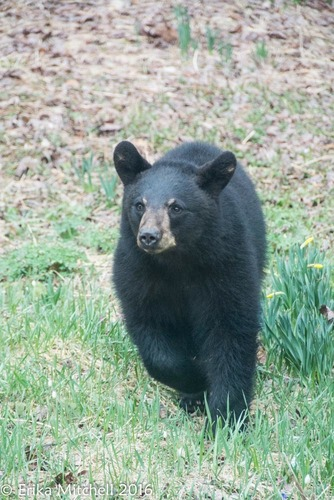

In [2]:
# Specify the location of your dataset
data_dir = pathlib.Path(r'D:\datasets\iNaturalCleaned_temp')

# Count the number of images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total number of images: {image_count}")

# Example: Load and display an image from the 'blackBear' folder
black_bears = list(data_dir.glob('blackBear/*'))
PIL.Image.open(str(black_bears[8]))

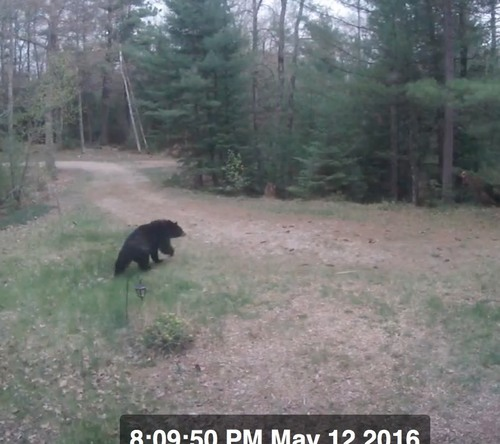

In [6]:
PIL.Image.open(str(black_bears[18]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset`.

[Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

Unlike the other notebook model training files I included. Here I increase the amount of pixels.

This creates a higher resolution. Here I am hoping to get some more fine detials in the images and see if the model can pick up on those details.

The thought behind this is that the images vary drastically in how zoomed in they are on the animal. This should help on those distinguishing features further away.

Batch size is the number of images the model processes together. 32 is a popular amount.

smaller amounts -> larger amounts
noiser gradients -> smoother gradients

In [2]:
batch_size = 32
img_height = 256
img_width = 256

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 5 classes.
Using 20000 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

['blackBear', 'coyote', 'ruffedGrouse', 'turkey', 'whitetailDeer']


## Visualize the data


Here are the first nine images from the training dataset:

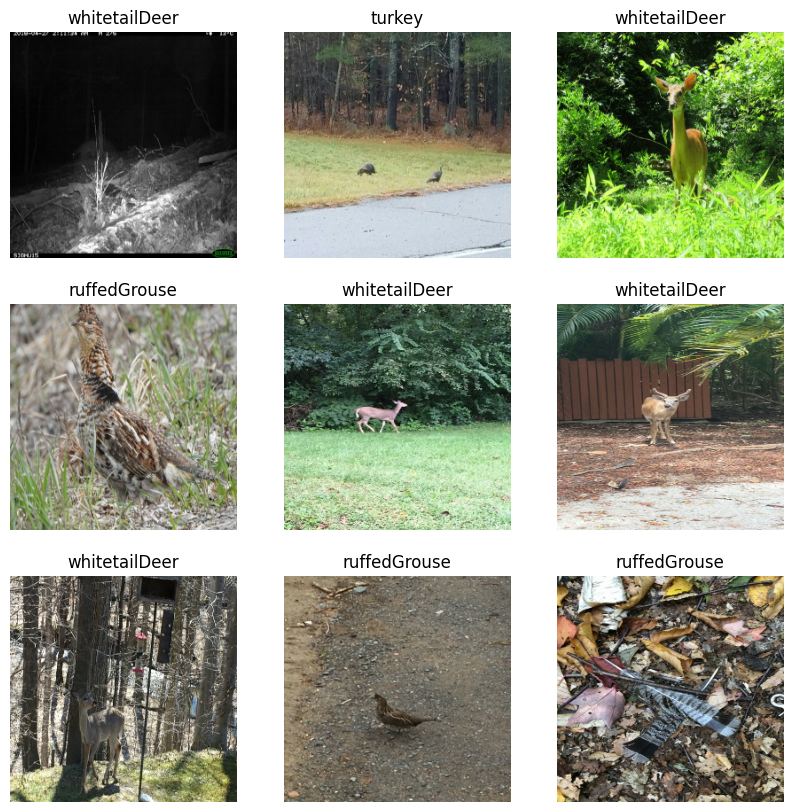

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

Buffered prefetching, so you can yield data from disk without having I/O become blocking.

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

About the above methods and how to cache data to disk [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [10]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

This applies the normalization layer to all the images in the training set.

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

4.9366674e-05 0.99858636


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`).

In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Define input shape
    layers.Rescaling(1./255),  # Rescale pixel values to [0, 1]
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### Compile the model

Uses `tf.keras.optimizers.Adam` optimizer 

> Optimizer controls how the model's weights are updated during training to minimize the loss.

> Adjust weights during backpropagation by using the loss.


<br>

and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. 

> Measures how well the model's predictions match the true labels.

> Calculate errors for multi-class classification.

<br>

Loss Computation:
The loss function calculates the error by comparing the predicted probabilities with the true classes.

Backward Pass:
The optimizer updates the model's weights to reduce the loss.

Performance Tracking:
The accuracy metric calculates and logs the proportion of correctly predicted samples.



<br>

To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 217s 344ms/step - accuracy: 0.2934 - loss: 1.6239 - val_accuracy: 0.4048 - val_loss: 1.4120
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 315ms/step - accuracy: 0.4752 - loss: 1.2960 - val_accuracy: 0.4744 - val_loss: 1.2992
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 314ms/step - accuracy: 0.5669 - loss: 1.1078 - val_accuracy: 0.5024 - val_loss: 1.2801
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.6868 - loss: 0.8318 - val_accuracy: 0.4942 - val_loss: 1.4338
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 183s 293ms/step - accuracy: 0.8236 - loss: 0.4933 - val_accuracy: 0.4850 - val_loss: 1.7308
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 286ms/step - accuracy: 0.9127 - loss: 0.2591 - val_accuracy: 0.4616 - val_loss: 2.5101
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 178s 284ms/step - accuracy: 0.9584 - loss: 0.1368 - val_accuracy: 0.4774 - val_loss: 3.0365
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 176s 281ms/step - accuracy: 0.9761 -

The increase in accuracy but decrease in validation accuracy is said to be a sign of overfitting or can also be a sign that the dataset is to complex for the size of the dataset that you are using to train it.

Solutions

- Increase dataset size (artifically using data augmenation if can not get mroe data)
- Stop early when validation accuracy starts to dip

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

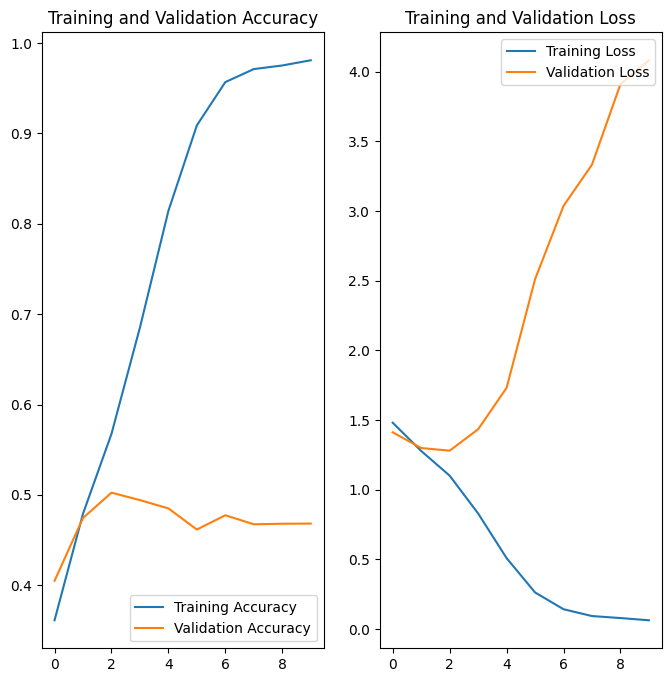

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. 

Use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

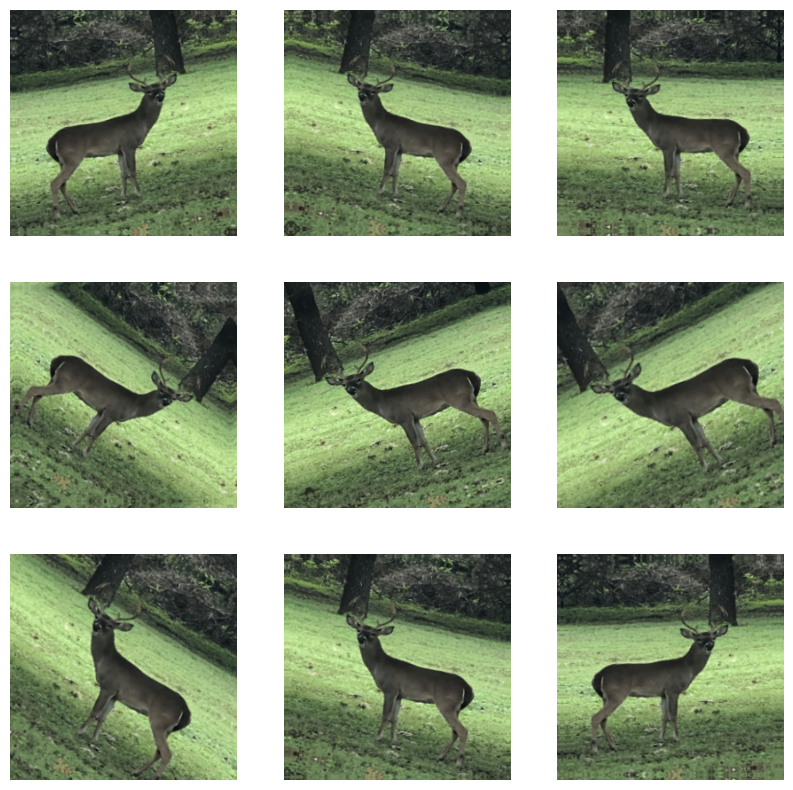

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

Overfitting could be seen by visualizing the training accuracy and the validation accuracy of models after training. Overfitting is when “the accuracy of models on the validation data would peak after training for a number of epochs and then stagnate or start decreasing.” (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). To help with overfitting a common tactic is using dropout. Dropout randomly selects a number of nodes / neurons and sets them to zero to deactivate them. For example, with ‘layers.Dropout(0.2),’ 20% of the neurons in the layer are randomly dropped during each training step, meaning 80% of the neurons remain active. This helps prevents overfitting by randomly deactivating neurons during training which forces the model to not rely on any specific set of nodes. That helps generalize better and encourages the model to learn more robust features that are not dependent on the presence of any specific node.

In [19]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,965 (32.09 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 324ms/step - accuracy: 0.2747 - loss: 1.6766 - val_accuracy: 0.3946 - val_loss: 1.4278
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 200s 320ms/step - accuracy: 0.4167 - loss: 1.3899 - val_accuracy: 0.4252 - val_loss: 1.4222
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 316ms/step - accuracy: 0.4462 - loss: 1.3331 - val_accuracy: 0.4460 - val_loss: 1.3392
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 315ms/step - accuracy: 0.4717 - loss: 1.2878 - val_accuracy: 0.4728 - val_loss: 1.2894
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 317ms/step - accuracy: 0.4932 - loss: 1.2525 - val_accuracy: 0.4884 - val_loss: 1.2585
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 316ms/step - accuracy: 0.4911 - loss: 1.2395 - val_accuracy: 0.4904 - val_loss: 1.2475
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 313ms/step - accuracy: 0.5163 - loss: 1.2075 - val_accuracy: 0.4860 - val_loss: 1.2789
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 312ms/step - accuracy: 0.5193 - loss: 1.19

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

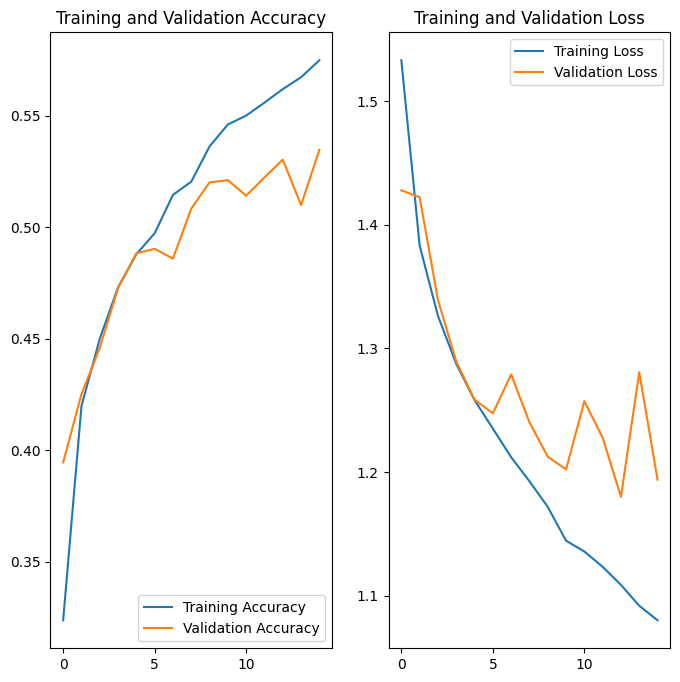

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Test out different animal images here

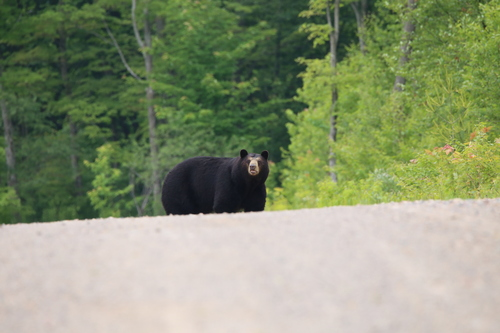

In [24]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))

In [25]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
This image most likely belongs to blackBear with a 98.46 percent confidence.


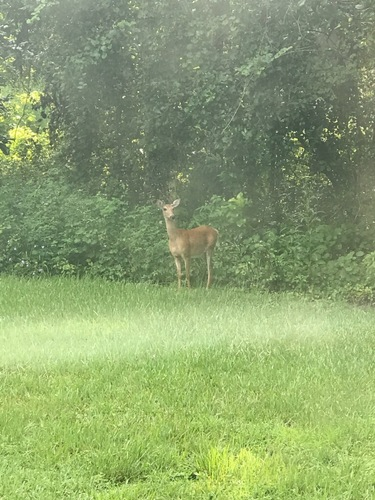

In [26]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('whitetailDeer/*'))
test_image_path = (test_image[5601])
PIL.Image.open(str(test_image[5601]))

In [27]:

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to whitetailDeer with a 81.85 percent confidence.


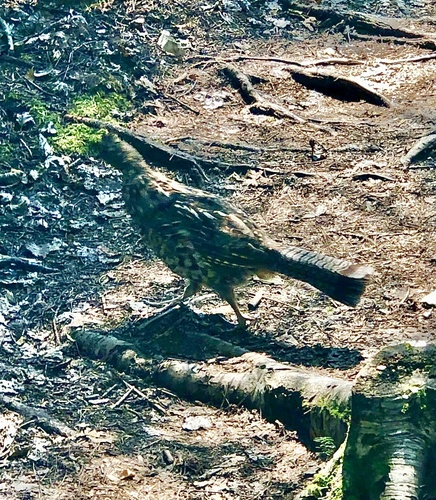

In [28]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('ruffedGrouse/*'))
test_image_path = (test_image[5656])
PIL.Image.open(str(test_image[5656]))

In [29]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This image most likely belongs to ruffedGrouse with a 49.82 percent confidence.


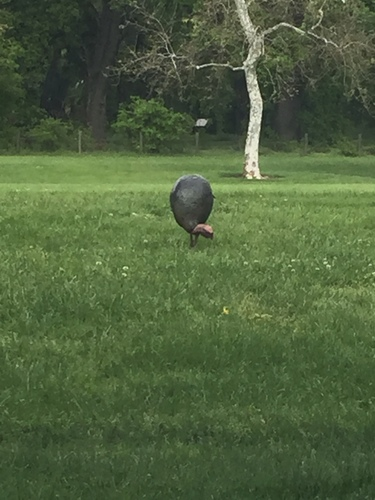

In [30]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('turkey/*'))
test_image_path = (test_image[5655])
PIL.Image.open(str(test_image[5655]))

In [31]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image most likely belongs to turkey with a 42.17 percent confidence.


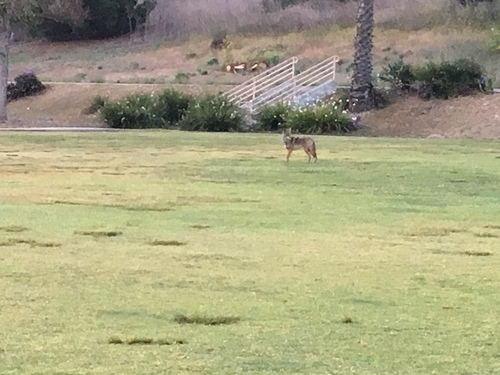

In [32]:
import os

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('coyote/*'))
test_image_path = (test_image[5604])
PIL.Image.open(str(test_image[5604]))

In [33]:
img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image most likely belongs to coyote with a 40.70 percent confidence.


## Save base model

In [34]:
# Save the model
model.save(r'C:\Users\kdlor\Documents\Documents\projects\trainingTrailSort\trailSortTF2MorePixels.keras')



## Running Model

### Load the Model

In [35]:
import tensorflow as tf

# Load the model
savedModel = tf.keras.models.load_model(r'C:\Users\kdlor\Documents\Documents\projects\trainingTrailSort\trailSortTF2MorePixels.keras')
savedModel.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,238,897 (96.28 MB)

 Trainable params: 8,412,965 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,825,932 (64.19 MB)

### Prepare Input Data

Need to preprocess the input data (images) similarly to how you did when training the model. This typically includes resizing the image and normalizing pixel values.

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    return img_array


### Predictions

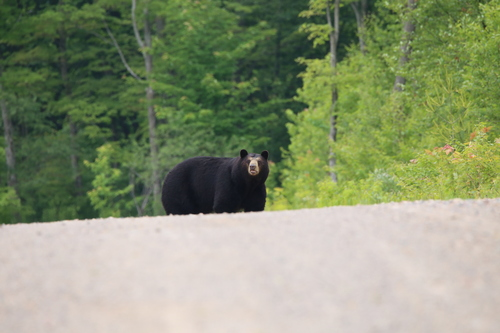

In [39]:
import os
import pathlib
import PIL

img_height = 256
img_width = 256
# Define the target size as per your model's input shape
target_size = (img_height, img_width)  # Set this according to your model

# Specify the location of your dataset
image_path = pathlib.Path(r'D:\datasets\iNaturalCleaned')

test_image = list(image_path.glob('blackBear/*'))
test_image_path = (test_image[5654])
PIL.Image.open(str(test_image[5654]))



In [40]:
# class_names = 0,1,2,3,4, - blackBear,coyote,ruffedGrouse,turkey,whitetailDeer
class_names = ["blackBear", "coyote", "ruffedGrouse", "turkey", "whitetailDeer"]

img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = savedModel.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
This image most likely belongs to blackBear with a 98.46 percent confidence.
